# Final Research Project

<img src= "tsp.png" width ="325" heigh ="100" align="right">
In this notebook we will find the summary of the work done in the NET 7429 course. Our research project consists of stages:

1. Understand what Graph Embedding Techniques are.
2. Select a pair of algorithms and apply them on a dataset.
3. Compare the results and determine which of the algorithms best fits the selected dataset.

Below you will find files that must be installed in order to import the necessary libraries for the project.

In [1]:
! pip install karateclub
! pip install randomwalk
! pip install gensim
! pip install umap
! pip install sklearn
! pip install tqdm
! pip install google
! pip install umap-learn
! pip install regressors
! pip install imblearn

Below you will find the libraries used for the elaboration of our analysis.

In [2]:
import networkx as nx
import json
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from scipy.linalg import sqrtm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from karateclub.utils.walker import RandomWalker, BiasedRandomWalker
from karateclub import DeepWalk, Node2Vec
from gensim.models.word2vec import Word2Vec
from regressors import stats
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix  
from imblearn.over_sampling import SMOTE
from visualization import plot_conf_mat

## Facebook Large Page-Page Network

This webgraph is a page-page graph of verified Facebook sites. Nodes represent official Facebook pages while the links are mutual likes between sites. Node features are extracted from the site descriptions that the page owners created to summarize the purpose of the site. This graph was collected through the Facebook Graph API in November 2017 and restricted to pages from 4 categories which are defined by Facebook:
1. Politicians
2. Governmental Organizations
3. Television Shows
4. Companies

In the next cell we will find the path where our dataset is located.

In [3]:
edges_path = 'facebook_edges.csv'
targets_path = 'facebook_target.csv'
features_path = 'facebook_features.json'

In the next cell we will find the instructions to read the dataset, its features and how they are related.

In [4]:
#Read in edges
edges = pd.read_csv(edges_path)

#Read in targets
targets = pd.read_csv(targets_path)
targets.index = targets.id


# Read in features
with open(features_path) as json_data:
    features = json.load(json_data)

max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

100%|██████████| 22470/22470 [00:00<00:00, 103054.60it/s]


In the next cell we convert our dataset into a graph, to which we will apply two graph embedding techniques for detecting communities. These techniques are:

1. Deep Walk
2. Node2Vec

In [23]:
# Read in Graph
graph = nx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2")
graph

### Deep Walk

Random Walk is a sequence of nodes, where next node is chosen randomly from the adjacent nodes. We need to choose randomly where to go next. This “walk” continues until we’ve reached the desired walk length. By repeating this random walk multiple times for all the nodes in the graph, we can get a bunch of “walk” sequences that contain useful information. 

In [6]:
# Do random walks
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(graph)

In [7]:
model = Word2Vec(walker.walks, hs=1, sg=1, window=10, min_count=1, workers=4)

In [8]:
embeddings = model.wv.vectors
print('Shape of embedding matrix:', embeddings.shape)

Shape of embedding matrix: (22470, 100)


DeepWalk model is trained, so we can use the embeddings for classification. We can quickly sense check the model by looking at the nearest neighbours in the embeddings space of some of the Facebook’s pages. 

In [100]:
similar_to = '2'
targets.loc[[int(similar_to)] + [int(v[0]) for v in model.wv.most_similar(similar_to)], :].head(n=10)

,id,facebook_id,page_name,page_type
id,,,,
2,2,144761358898518,ESET,company
9048,9048,224733310904258,ESET,company
15378,15378,163138753704089,ESET,company
21275,21275,354560867800,ESET,company
5857,5857,170109086352159,ESET,company
13205,13205,143294009022313,ESET,company
1533,1533,288306190406,ESET,company
126,126,124157780951417,ESET,company
19969,19969,321440834594,ESET,company


We can build a simple Random Forest model to see what performance we can achieve purely using the embeddings.

In [63]:
# Get targets 
y = targets.loc[[int(i) for i in list(features.keys())], 'page_type']

In [64]:
# Get corresponding embeddings
X_dw = []
for i in y.index:
    X_dw.append(model.wv.__getitem__(str(i)))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_dw, y, test_size=0.3) 

# Train RF model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate
print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

0.9307224447411363
[[0.95354773 0.02756508 0.00408372 0.01480347]
 [0.01894123 0.94560466 0.03448276 0.00097135]
 [0.00860585 0.04417671 0.94262765 0.00458979]
 [0.12244898 0.02040816 0.0244898  0.83265306]]


Here we can observe the accuracy of our model. In the following table we have the comparison between the predicted labels and the true ones within the Facebook pages.

In [65]:
pd.DataFrame({'true':y_test,'pred':y_pred})

,true,pred
id,,
17107,tvshow,tvshow
2124,government,government
17863,company,company
12028,company,company
19813,government,government
...,...,...
7395,tvshow,tvshow
9676,company,company
1261,politician,politician


In [67]:
from sklearn.preprocessing import LabelEncoder
y_test_encoder = LabelEncoder()
pred_encoder = LabelEncoder()

In [68]:
y_test_encoder.fit(y_test)
label_train = y_test_encoder.transform(y_test)
y_test = label_train.tolist()

pred_encoder.fit(y_pred)
label_train = pred_encoder.transform(y_pred)
y_pred = label_train.tolist()

As we can see, our model has a high accuracy.

In [69]:
accuracy_score(y_pred, y_test)

0.9307224447411363

Next we present the Normalized Confusion Matrix of our model. In it we can see that it classifies the elements within our dataset very well.

Normalized confusion matrix
[[0.95354773 0.02756508 0.00408372 0.01480347]
 [0.01894123 0.94560466 0.03448276 0.00097135]
 [0.00860585 0.04417671 0.94262765 0.00458979]
 [0.12244898 0.02040816 0.0244898  0.83265306]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

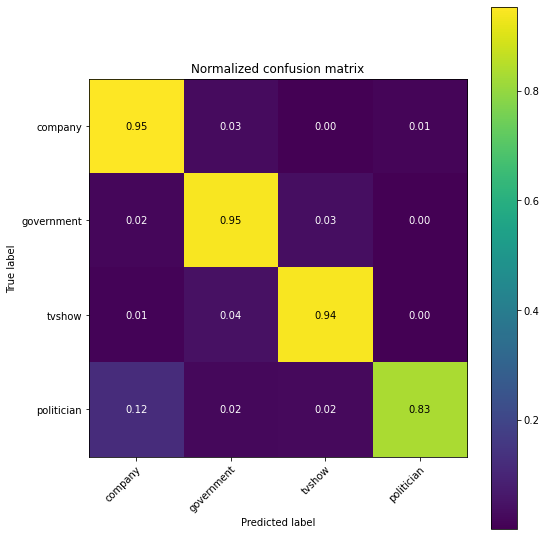

In [71]:
class_names=np.array(["company", "government","tvshow","politician"] )
plot_conf_mat(y_test, y_pred, class_names)

The following graph is to observe the communities that could exist within our dataset. As we can see there are 3 categories that can be distinguished. Company, Government and television shows are nodes that managed to be classified in clusters. When it comes to likes between pages, it makes sense that these communities are formed. However, politicians fail to belong to a community. This may be because not everyone likes the same pages and as we can see, there are certain sectors that are grouped into small communities.

In [72]:
dw_micro_f1_scores = []
dw_macro_f1_scores = []
for train_size in tqdm(np.arange(0.05, 1, 0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X_dw, y, 
                                                        train_size=train_size,
                                                        random_state=42)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mic = f1_score(y_test, y_pred, average='micro')
    mac = f1_score(y_test, y_pred, average='macro')
    dw_micro_f1_scores.append(mic)
    dw_macro_f1_scores.append(mac)  

100%|██████████| 19/19 [02:59<00:00,  9.45s/it]


[]

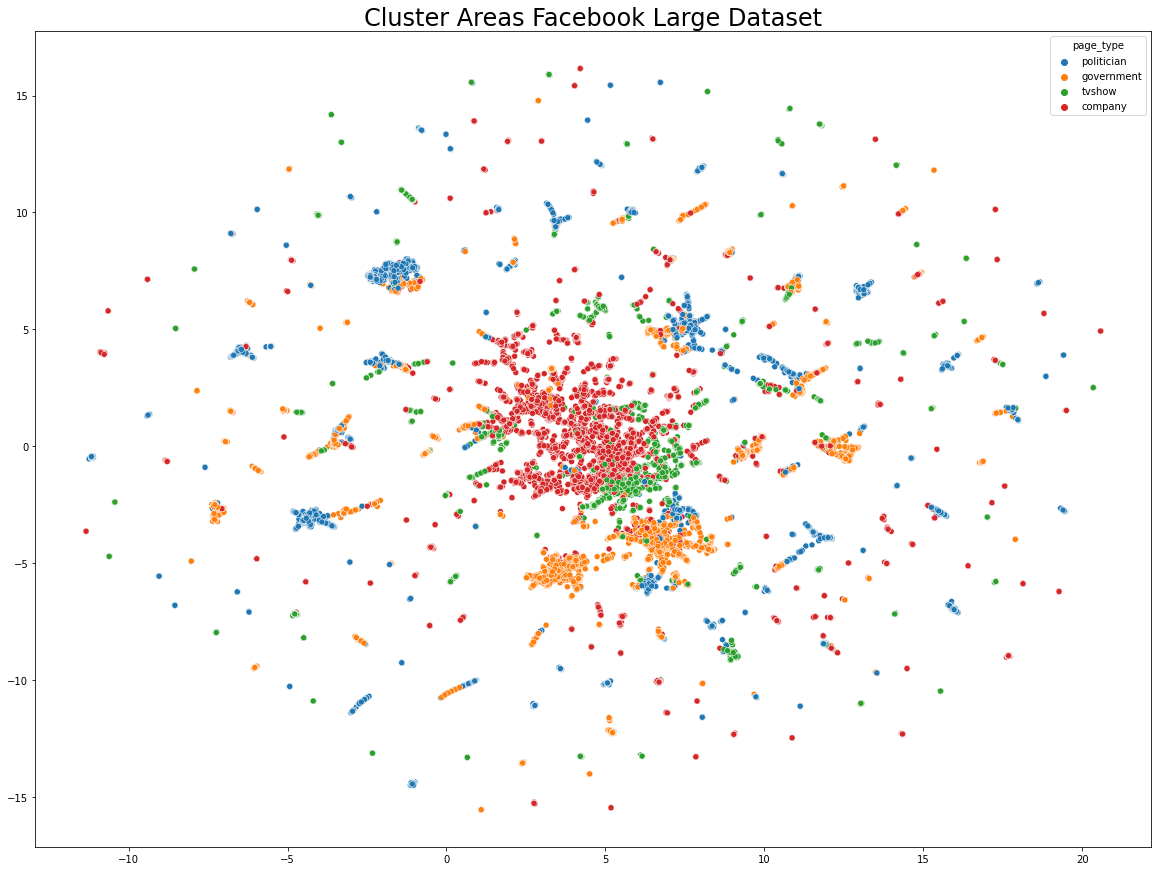

In [73]:
u = umap.UMAP(random_state=42)
dw_umap_embs = u.fit_transform(X_dw)
plt.figure(figsize=(20, 15))
ax = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = y)
plt.title('Cluster Areas Facebook Large Dataset', fontsize=24)
plt.savefig('Cluster_DeepWalk.png') 
plt.plot()

These results were obtained with the unbalanced training set. We apply SMOTE in order to balance the categories and see if we achieve any impact on the accuracy of the model.

In [75]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
pd.value_counts(y_train_balanced)

company       6548
politician    6548
government    6548
tvshow        6548
Name: page_type, dtype: int64

In [76]:
rf = RandomForestClassifier()
rf.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = rf.predict(X_test)

As we can see, the accuracy of the model increased. And if we look at the balanced Normalized Confusion Matrix we see that it ranks pages better on Facebook.

In [78]:
accuracy_score(y_pred_balanced, y_test)

0.9368327402135231

In [79]:
y_test_encoder.fit(y_test)
label_train = y_test_encoder.transform(y_test)
y_test = label_train.tolist()

pred_encoder.fit(y_pred_balanced)
label_train = pred_encoder.transform(y_pred_balanced)
y_pred_balanced = label_train.tolist()

Normalized confusion matrix
[[0.92634561 0.0509915  0.         0.02266289]
 [0.02409639 0.95180723 0.02108434 0.00301205]
 [0.         0.03521127 0.96478873 0.        ]
 [0.06451613 0.04516129 0.01290323 0.87741935]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

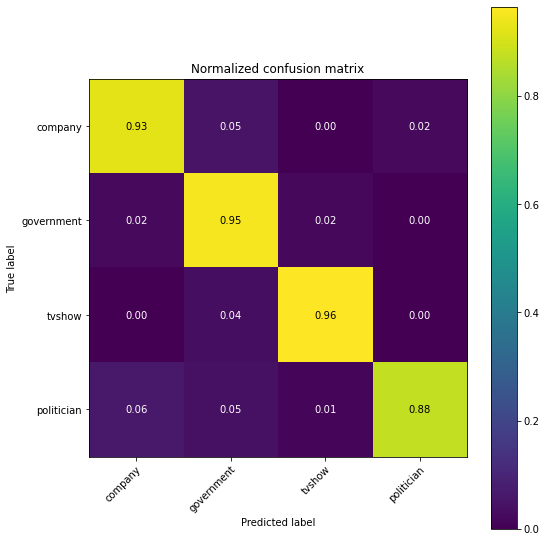

In [81]:
plot_conf_mat(y_test, y_pred_balanced,class_names)

### Node2Vec

Node2Vec is very similar to DeepWalk, but the random walks are generated a bit differently. Recall that in the pure random walk, neighbourhood nodes have an equal probability to be chosen as next step.
Here instead, we have 2 hyperparameters to tune - p and q. p and q control how fast the walk explores and leaves the neighbourhood of the starting node u.

1. p - high value means that we’re less likely to return to the previous node
2. q - high value approximates the Breadth-First-Search meaning that the neighbourhood around the node is explored. Low values give higher chance to go outside the neighbourhood and hence approximates the Depth-First-Search

p = 10, q = 0.1 - here we expect the random walk to go outwards and explore the adjacent clusters as well

In [104]:
b_walker = BiasedRandomWalker(80, 10, 10, 0.1)
b_walker.do_walks(graph)

In [105]:
node_vec = Word2Vec(b_walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 window=10,
                 min_count=1,
                 workers=4,
                 seed=42)

We can build a simple Random Forest model to see what performance we can achieve purely using the embeddings.

In [106]:
# Get corresponding Node2Vec embeddings
X_node_vec = []
for i in y.index:
    X_node_vec.append(node_vec.wv.__getitem__(str(i)))

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_node_vec, y, test_size=0.2) # train/test split

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

0.9310191366266133
[[9.45359281e-01 2.91916168e-02 5.23952096e-03 2.02095808e-02]
 [1.67516387e-02 9.44646759e-01 3.78732702e-02 7.28332119e-04]
 [8.03571429e-03 5.53571429e-02 9.34821429e-01 1.78571429e-03]
 [7.96992481e-02 2.55639098e-02 2.70676692e-02 8.67669173e-01]]


Here we can observe the accuracy of our model. In the following table we have the comparison between the predicted labels and the true ones within the Facebook pages.

In [108]:
pd.DataFrame({'true':y_test,'pred':y_pred})

,true,pred
id,,
11018,government,government
7361,government,government
16403,politician,politician
4508,politician,politician
697,government,government
...,...,...
12199,politician,politician
2277,tvshow,tvshow
7952,politician,politician


As we can see, our model has a high accuracy.

In [109]:
accuracy_score(y_pred, y_test)

0.9310191366266133

In [110]:
y_test_encoder.fit(y_test)
label_train = y_test_encoder.transform(y_test)
y_test = label_train.tolist()

pred_encoder.fit(y_pred)
label_train = pred_encoder.transform(y_pred)
y_pred = label_train.tolist()

Next we present the Normalized Confusion Matrix of our model. In it we can see that it classifies the elements within our dataset very well.

Normalized confusion matrix
[[9.45359281e-01 2.91916168e-02 5.23952096e-03 2.02095808e-02]
 [1.67516387e-02 9.44646759e-01 3.78732702e-02 7.28332119e-04]
 [8.03571429e-03 5.53571429e-02 9.34821429e-01 1.78571429e-03]
 [7.96992481e-02 2.55639098e-02 2.70676692e-02 8.67669173e-01]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

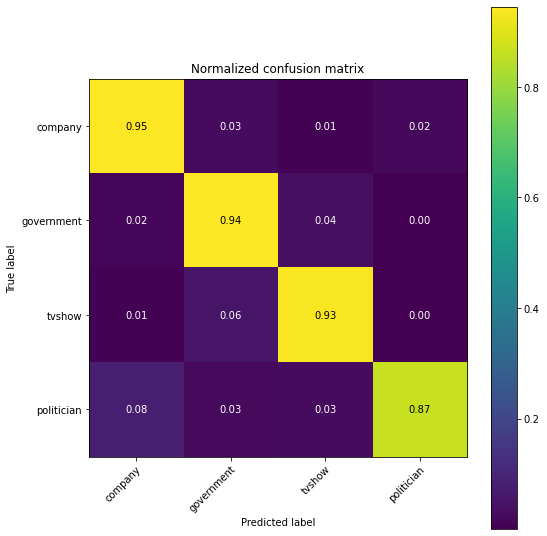

In [111]:
class_names=np.array(["company", "government","tvshow","politician"] )
plot_conf_mat(y_test, y_pred, class_names)

In [112]:
nv_micro_f1_scores = []
nv_macro_f1_scores = []
for train_size in tqdm(np.arange(0.05, 1, 0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X_node_vec, y, 
                                                        train_size=train_size,
                                                        random_state=42)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mic = f1_score(y_test, y_pred, average='micro')
    mac = f1_score(y_test, y_pred, average='macro')
    nv_micro_f1_scores.append(mic)
    nv_macro_f1_scores.append(mac)

100%|██████████| 19/19 [02:55<00:00,  9.23s/it]


As we can see, the behavior is very similar to that of Deep Walk. We see again that the communities that were formed before are formed. With this we can realize that both Deep Walk and Node2Vec are quite good algorithms for community prediction.

[]

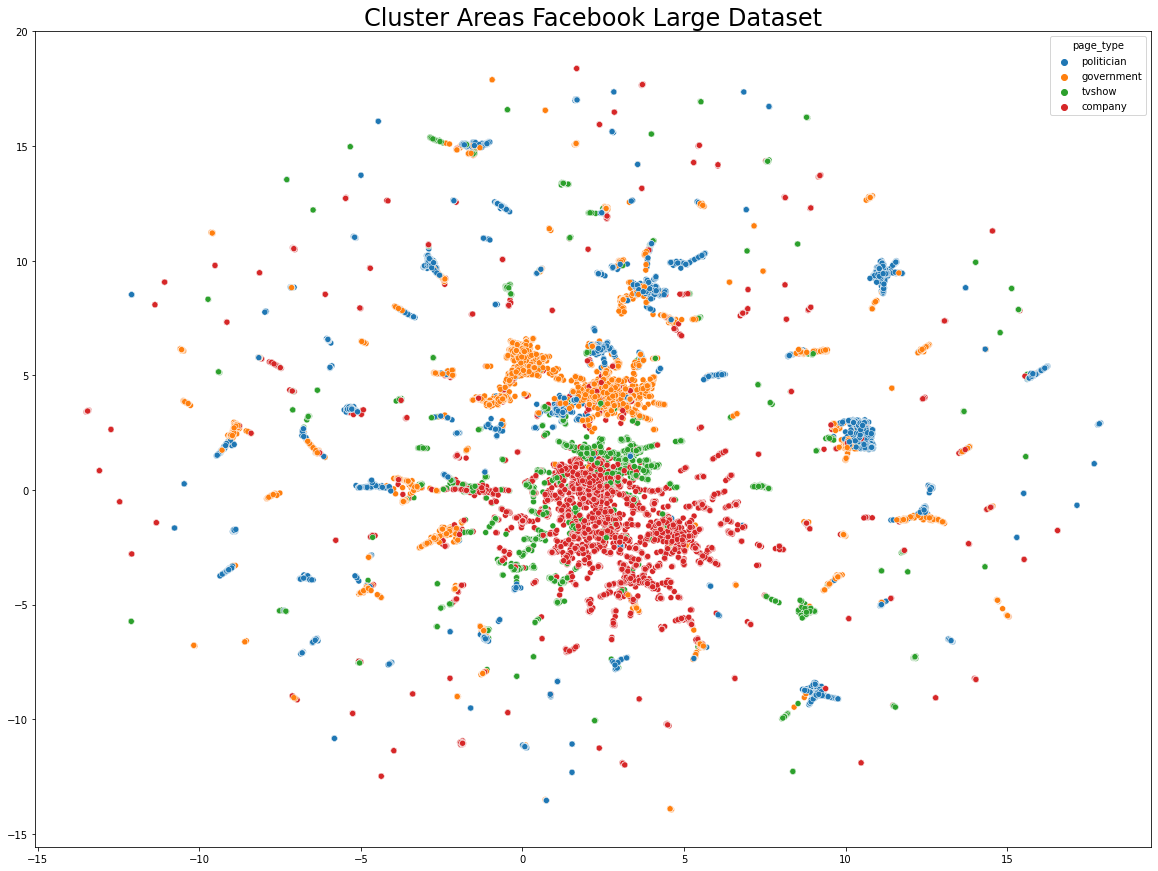

In [113]:
u = umap.UMAP(random_state=42)
nv_umap_embs = u.fit_transform(X_node_vec)
plt.figure(figsize=(20, 15))
ax = sns.scatterplot(x = nv_umap_embs[:, 0], y = nv_umap_embs[:, 1], hue = y)
plt.title('Cluster Areas Facebook Large Dataset', fontsize=24)
plt.savefig('Cluster_Node2Vec.png') 
plt.plot()

These results were obtained with the unbalanced training set. We apply SMOTE in order to balance the categories and see if we achieve any impact on the accuracy of the model.

In [114]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
pd.value_counts(y_train_balanced)

company       6548
politician    6548
government    6548
tvshow        6548
Name: page_type, dtype: int64

In [115]:
rf = RandomForestClassifier()
rf.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = rf.predict(X_test)

In [116]:
accuracy_score(y_pred_balanced, y_test)

0.9279359430604982

In [117]:
y_test_encoder.fit(y_test)
label_train = y_test_encoder.transform(y_test)
y_test = label_train.tolist()

pred_encoder.fit(y_pred_balanced)
label_train = pred_encoder.transform(y_pred_balanced)
y_pred_balanced = label_train.tolist()

As we can see the value of the model pressure has decreased a little. However, if we look at the Normalized Confusion Matrix, we can see that the model better classifies the labels associated with Facebook pages.

Normalized confusion matrix
[[0.92917847 0.04532578 0.         0.02549575]
 [0.02409639 0.93975904 0.03012048 0.0060241 ]
 [0.00352113 0.05985915 0.92957746 0.00704225]
 [0.07096774 0.01935484 0.01290323 0.89677419]]


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

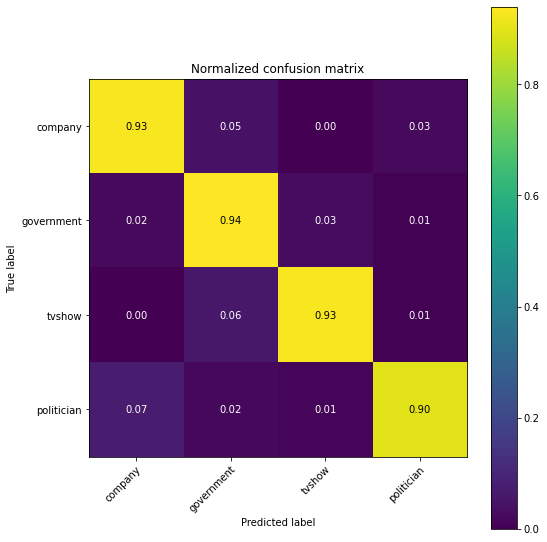

In [118]:
plot_conf_mat(y_test, y_pred_balanced,class_names)

### Deep Walk vs Node2Vec

[]

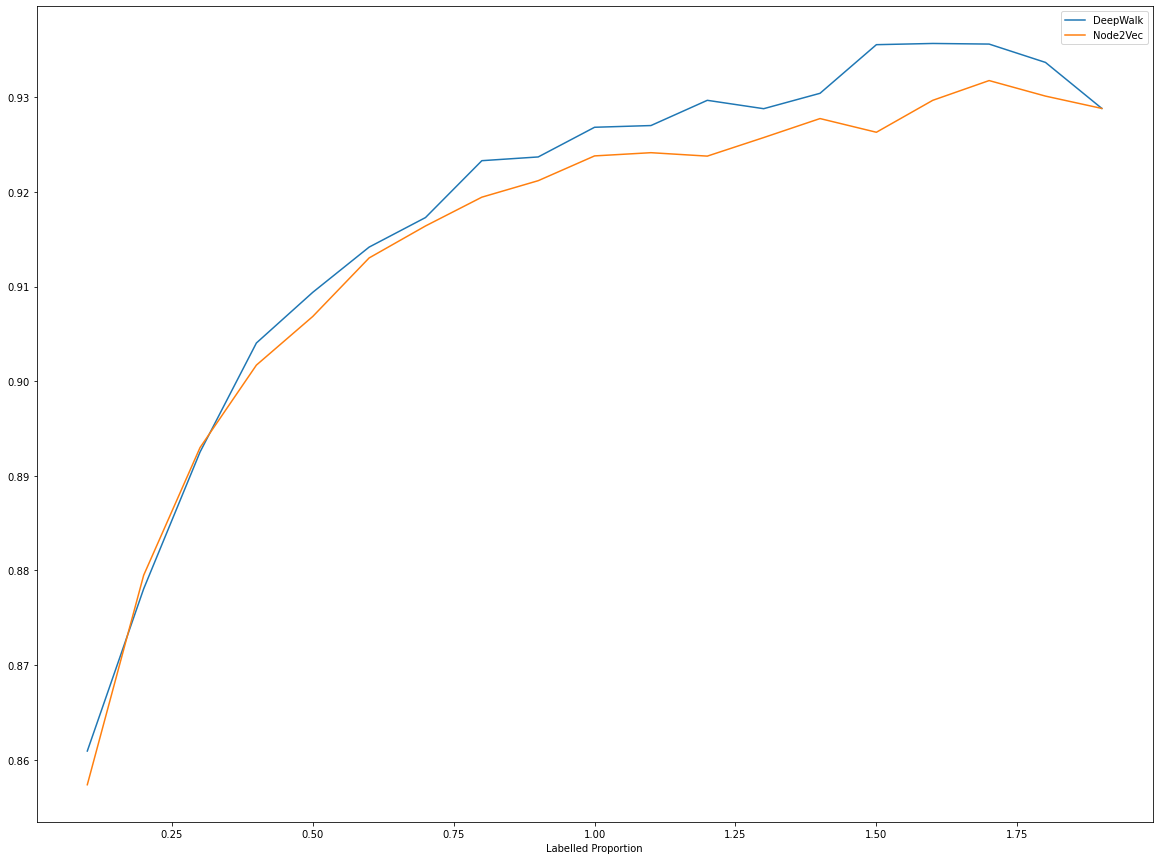

In [119]:
plt.figure(figsize=(20, 15))
sns.lineplot(x = np.arange(0.1, 2, 0.1), y = dw_micro_f1_scores, label='DeepWalk')
sns.lineplot(x = np.arange(0.1, 2, 0.1), y = nv_micro_f1_scores, label='Node2Vec')
plt.xlabel('Labelled Proportion')
plt.plot()

In the following graph we are comparing the values that both datasets had at the time of training and obtaining the embeddings associated with the Facebook Large Dataset. As we can see, both models converge to similar values of score F1. However, as we can see in the previous Normalized Confusion Matrix, we can infer that Node2Vec is a superior model for community detection. When the data is balanced, this model tends to provide the best results.